# Predict Future Sales Solution

In this competiotion we were provided with a dataset of historical transactions of 60 retail stores over a period of around 2.5 years.
The task is to forecast the total amount of products sold in every shop for the test set.

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import linear_model

In [2]:
test = pd.read_csv('test.csv')
categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
sales_train = pd.read_csv('sales_train_v2.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### File descriptions 

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.   
test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.   sample_submission.csv - a sample submission file in the correct format.   
items.csv - supplemental information about the items/products.   
item_categories.csv - supplemental information about the items categories.   
shops.csv- supplemental information about the shops.  

### Data fields 

ID -  an Id that represents a (Shop, Item) tuple within the test set  
shop_id - unique identifier of a shop  
item_id - unique identifier of a product   
item_category_id - unique identifier of item category   
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure  
item_price - current price of an item  
date - date in format dd/mm/yyyy   
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33   
item_name - name of item   
shop_name - name of shop   
item_category_name - name of item category  

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# EDA

In [5]:
sales_train = sales_train.merge(items, on = ['item_id'], how = 'left')

#### plot sales per category

In [6]:
sales_per_category = sales_train.groupby(['item_category_id'])['item_cnt_day'].sum().to_frame('item_cnt').reset_index()

Text(0.5, 1.0, 'Items Sold Per Category')

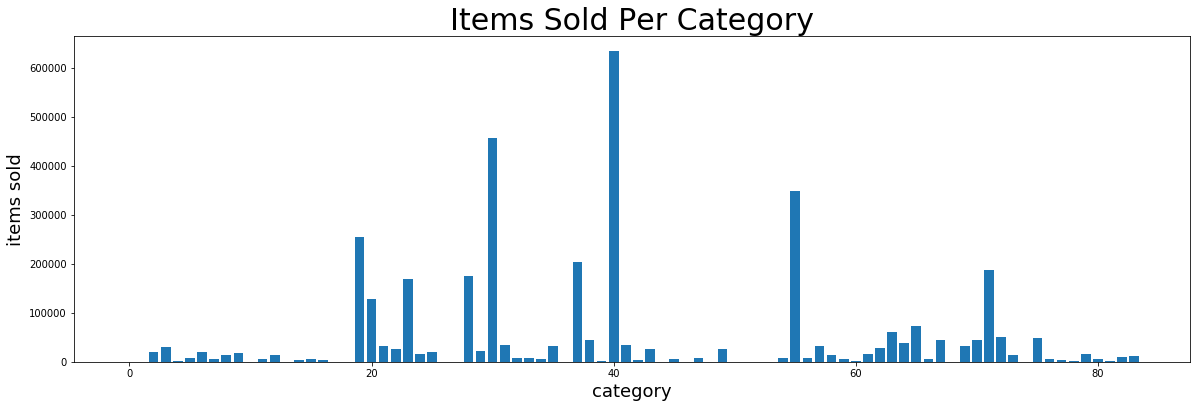

In [7]:
plt.figure(figsize=(20, 6))
plt.bar(sales_per_category['item_category_id'], sales_per_category['item_cnt'])
plt.xlabel('category', fontsize = 18)
plt.ylabel('items sold', fontsize = 18)
plt.title('Items Sold Per Category', fontsize = 30)

We can see that the amount sold can very alot between categories. This can be a feature

#### plot sales per item

Text(0.5, 1.0, 'Units Sold Per Item')

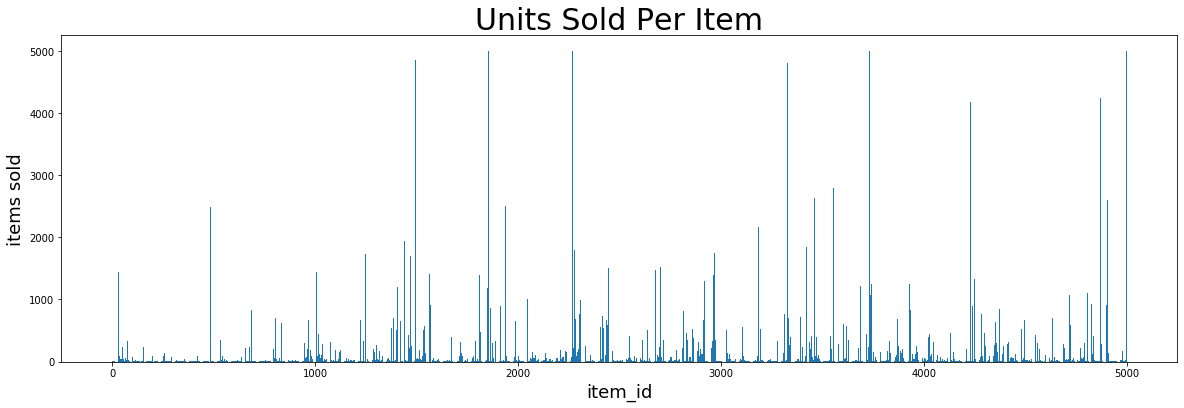

In [8]:
sales_per_item = sales_train.groupby(['item_id'])['item_cnt_day'].sum().to_frame('item_cnt').reset_index().clip(0,5000)
plt.figure(figsize=(20, 6))
plt.bar(sales_per_item['item_id'], sales_per_item['item_cnt'])
plt.xlabel('item_id', fontsize = 18)
plt.ylabel('items sold', fontsize = 18)
plt.title('Units Sold Per Item', fontsize = 30)

We can see that the amount sold can very alot between items. This can be a feature

#### sales per shop

Text(0.5, 1.0, 'Units Sold Per Shop')

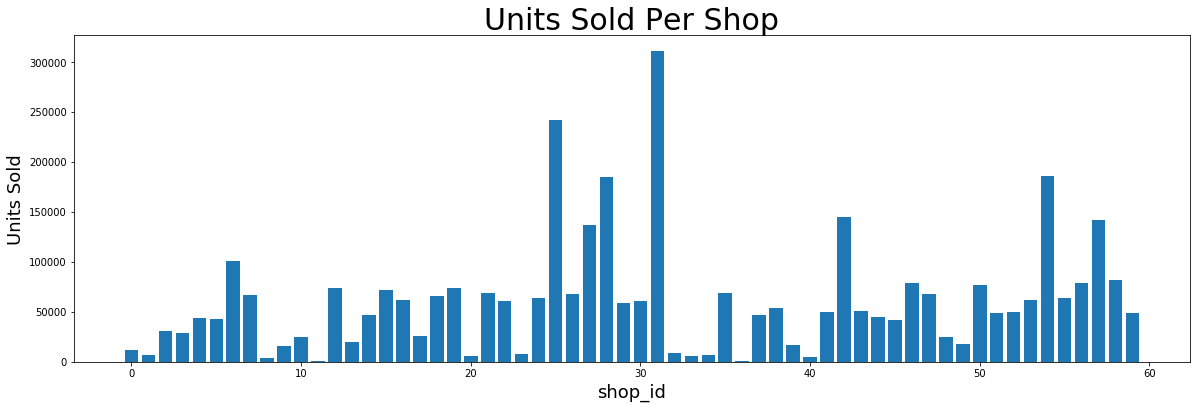

In [9]:
sales_per_shop = sales_train.groupby(['shop_id'])['item_cnt_day'].sum().to_frame('item_cnt').reset_index()
plt.figure(figsize=(20, 6))
plt.bar(sales_per_shop['shop_id'], sales_per_shop['item_cnt'])
plt.xlabel('shop_id', fontsize = 18)
plt.ylabel('Units Sold', fontsize = 18)
plt.title('Units Sold Per Shop', fontsize = 30)

shop_id is less discriminative, but maybe can still be used as a feature

### sales per month

Text(0.5, 1.0, 'Units Sold Per Month')

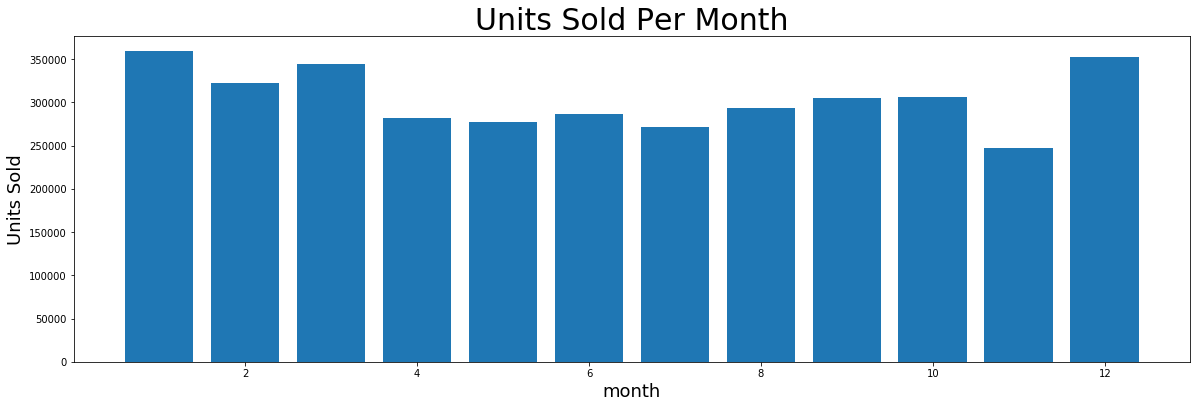

In [10]:
sales_train['month'] = sales_train['date_block_num'].mod(12) + 1
sales_per_month = sales_train.groupby(['month'])['item_cnt_day'].sum().to_frame('item_cnt').reset_index()
plt.figure(figsize=(20, 6))
plt.bar(sales_per_month['month'], sales_per_month['item_cnt'])
plt.xlabel('month', fontsize = 18)
plt.ylabel('Units Sold', fontsize = 18)
plt.title('Units Sold Per Month', fontsize = 30)

there is some pattern here, but not very distinct, I will not use the month as a feature

### Items sold per item per shop

In [11]:
sales_per_item_per_shop = sales_train.groupby(['item_id', 'shop_id'])['item_cnt_day'].sum().to_frame('item_cnt').reset_index()

In [12]:
sales_per_item_per_shop['item_shop_id'] = 'item_' + sales_per_item_per_shop['item_id'].map(str) + '_shop_' + str(sales_per_item_per_shop['shop_id'].map(str))

In [13]:
sales_per_item_per_shop_sample = sales_per_item_per_shop.sample(frac = 0.001)

Text(0.5, 1.0, 'Units Sold Per Item and Shop')

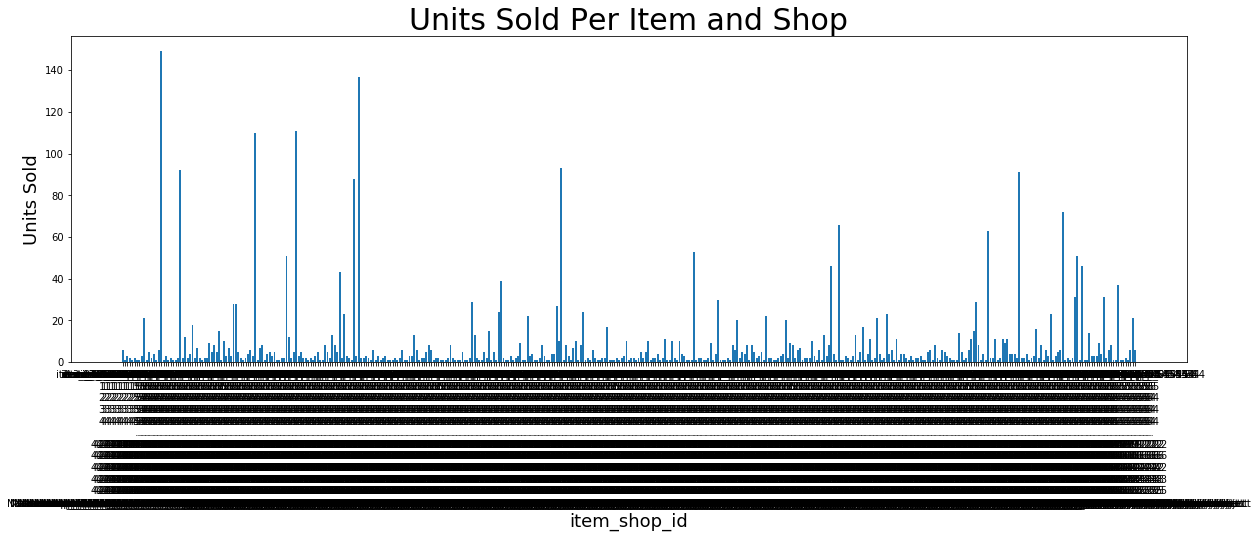

In [14]:
plt.figure(figsize=(20, 6))
plt.bar(sales_per_item_per_shop_sample['item_shop_id'], sales_per_item_per_shop_sample['item_cnt'])
plt.xlabel('item_shop_id', fontsize = 18)
plt.ylabel('Units Sold', fontsize = 18)
plt.title('Units Sold Per Item and Shop', fontsize = 30)

looks discriminative, a feature combining item_id and shop_id can help

### Histograms of the raw data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48943ee710>,
      dtype=object)

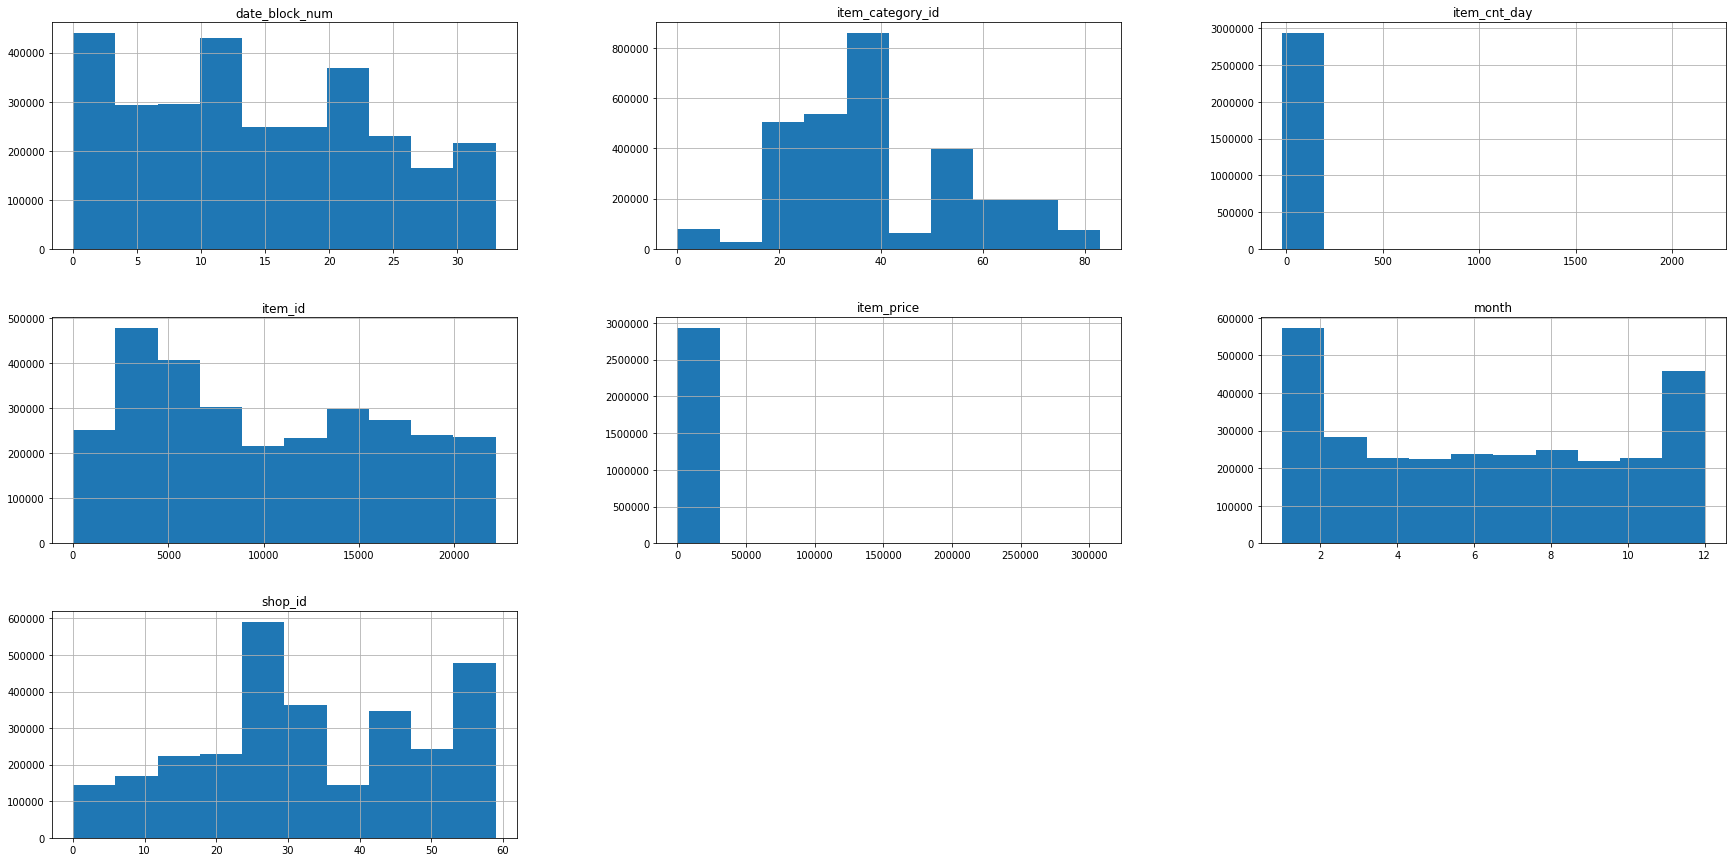

In [15]:
sales_train.hist(figsize=(30,15))

there are huge outliers in item_cnt and item_price, we should handle them

### handle item_cnt outliers

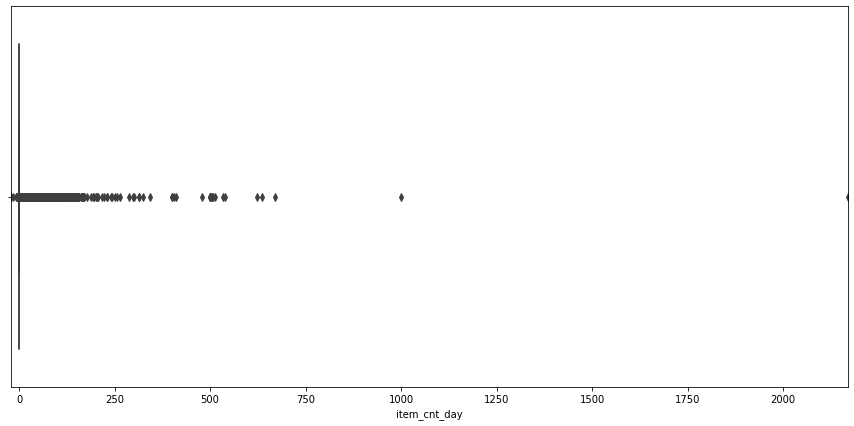

In [16]:
plt.figure(figsize=(15,7))
plt.xlim(sales_train.item_cnt_day.min(), sales_train.item_cnt_day.max())
sns.boxplot(sales_train.item_cnt_day)

let's drop the counts above 1000

In [17]:
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

### handle price outliers

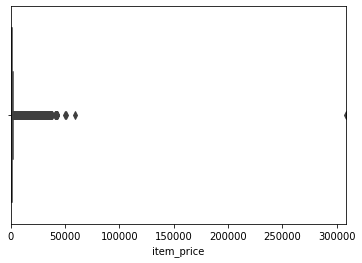

In [18]:
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max())
sns.boxplot(sales_train.item_price)

In [19]:
sales_train = sales_train[sales_train['item_price'] < 100000]

### Analyze items data

In [20]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [21]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [22]:
items[items.item_name.str.contains('ABBYY FineReader')].item_name

1       !ABBYY FineReader 12 Professional Edition Full...
1149    ABBYY FineReader 10 Home Edition (ABBY) [PC, Ц...
1150    ABBYY FineReader 10 Home Edition Full (версия ...
1151      ABBYY FineReader 10 Home Edition Full (коробка)
1152    ABBYY FineReader 11 Professional Edition (ABBY...
1153    ABBYY FineReader 11 Professional Edition Full ...
1154    ABBYY FineReader 12 Professional Edition 1 yea...
1155    ABBYY FineReader 12 Professional Edition Full ...
1156    ABBYY FineReader 12 Professional Edition на 1 ...
1157    ABBYY FineReader 12 Professional Full (версия ...
1158    ABBYY FineReader Express Edition для Mac Full ...
1159    ABBYY FineReader Pro для Mac Full (версия для ...
Name: item_name, dtype: object

I don't see any special feature to extract from the items' data

### Analyze categories data

In [23]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [24]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


category_name can be split to category and sub category, I will use that in the feature generation

### Clip values

Clipping the values per the recommendation of the competition owners. This is what they do to the test set

In [25]:
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0,20)

> ### Monthly Stats

aggregating the raw data, which is daily transactions, to monthly sales, which is the series we would like to forecast. The target variable is the amount sold per month per item per shop

In [26]:
class MonthlyStatsExtractor(BaseEstimator, TransformerMixin):
    def fit(self, df, y = None, **fit_params):
        return self
    def transform(self, df, **transform_params):
        items_per_month_df = df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().to_frame('target').reset_index()
        avg_item_price_df = df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().to_frame('prev_month_avg_item_shop_price').reset_index()
        avg_item_price_df['date_block_num'] = avg_item_price_df['date_block_num'] + 1
        valid_item_shop_month_triplets = []
        for date_block_num in df['date_block_num'].unique():
            monthly_entries = df[df['date_block_num'] == date_block_num]
            valid_item_shop_month_triplets.append(np.array([triplet for triplet in product([date_block_num], monthly_entries['shop_id'].unique(), monthly_entries['item_id'].unique())]))
        all_vals_df = pd.DataFrame(np.vstack(valid_item_shop_month_triplets), columns=['date_block_num', 'shop_id', 'item_id'])
        all_vals_df = all_vals_df.merge(items_per_month_df, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        all_vals_df = all_vals_df.merge(avg_item_price_df, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        all_vals_df['target'] = all_vals_df['target'].fillna(0)
        return all_vals_df

In [27]:
monthly_vals_df = MonthlyStatsExtractor().fit_transform(sales_train)
monthly_vals_df.tail()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price
10913799,33,21,7635,0.0,NaN
10913800,33,21,7638,0.0,NaN
10913801,33,21,7640,0.0,NaN
10913802,33,21,7632,0.0,NaN
10913803,33,21,7440,0.0,NaN


In [28]:
monthly_vals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 5 columns):
date_block_num                    int64
shop_id                           int64
item_id                           int64
target                            float64
prev_month_avg_item_shop_price    float64
dtypes: float64(2), int64(3)
memory usage: 499.6 MB


### Mean Encoding

A transformer to be used to mean target encode the categorical features(item_id, shop_id, item category)

In [29]:
class MeanEncodingExtractor(BaseEstimator, TransformerMixin):
    
    def fit_transform(self, df, y = None, **fit_params):
        feature_to_encode = fit_params['feature_to_encode']
        encoded_feature = pd.DataFrame(columns= [feature_to_encode, feature_to_encode+'_mean_target_encoded', 'date_block_num'])
        for date_block_num in df['date_block_num'].unique():
            prev_months_df = df[df['date_block_num'] < date_block_num]
            curr_month_encoded_feature = prev_months_df.groupby([feature_to_encode])['target'].mean().to_frame(feature_to_encode+'_mean_target_encoded').reset_index()
            curr_month_encoded_feature['date_block_num'] = date_block_num
            encoded_feature = pd.concat([encoded_feature, curr_month_encoded_feature], sort= True)
        encoded_feature[feature_to_encode] = encoded_feature[feature_to_encode].astype(df[feature_to_encode].dtype)
        encoded_feature['date_block_num'] = encoded_feature['date_block_num'].astype(np.int8)
        return df.merge(encoded_feature, on = [feature_to_encode, 'date_block_num'], how = 'left')

In [30]:
mean_enc_df = MeanEncodingExtractor().fit_transform(monthly_vals_df,feature_to_encode = 'shop_id')

In [31]:
mean_enc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 6 columns):
date_block_num                    int64
shop_id                           int64
item_id                           int64
target                            float64
prev_month_avg_item_shop_price    float64
shop_id_mean_target_encoded       float64
dtypes: float64(3), int64(3)
memory usage: 582.9 MB


In [32]:
mean_enc_df.tail()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,shop_id_mean_target_encoded
10913799,33,21,7635,0.0,NaN,0.289631
10913800,33,21,7638,0.0,NaN,0.289631
10913801,33,21,7640,0.0,NaN,0.289631
10913802,33,21,7632,0.0,NaN,0.289631
10913803,33,21,7440,0.0,NaN,0.289631


### Extract category, sub-category and shop city

In [33]:
category_and_sub_category = categories['item_category_name'].str.split("-", n = 1, expand = True)
categories['category'] = category_and_sub_category[0].fillna('')
categories['category'] = LabelEncoder().fit_transform(categories['category'])
categories['sub_category'] = category_and_sub_category[1].fillna('')
categories['sub_category'] = LabelEncoder().fit_transform(categories['sub_category'])
categories.head()

,item_category_name,item_category_id,category,sub_category
0,PC - Гарнитуры/Наушники,0,0,31
1,Аксессуары - PS2,1,1,12
2,Аксессуары - PS3,2,1,13
3,Аксессуары - PS4,3,1,14
4,Аксессуары - PSP,4,1,16


In [34]:
shops['shop_city'] = shops['shop_name'].str.split(n=1, expand = True)[0]
shops['shop_city'] = shops['shop_city'].str.replace('\W', '')
shops.head()
shops['shop_city'] = LabelEncoder().fit_transform(shops['shop_city'])

In [35]:
class ShopItemCategoryExtractor(BaseEstimator, TransformerMixin):
    def fit(self, df, y = None, **fit_params):
        self.items_df = fit_params['items']
        self.categories_df = fit_params['categories']
        self.shops_df = fit_params['shops']
        return self
    def transform(self, df):
        df_with_category_and_item = df.merge(self.items_df, on = ['item_id'], how = 'left')
        df_with_category_and_item = df_with_category_and_item.merge(self.categories_df, on = 'item_category_id', how = 'left')
        df_with_category_and_item = df_with_category_and_item.merge(self.shops_df, on = 'shop_id', how = 'left')
        return df_with_category_and_item.drop(['item_category_name', 'shop_name', 'item_name'], axis = 'columns')

In [36]:
shop_category_df = ShopItemCategoryExtractor().fit_transform(monthly_vals_df, items = items, categories = categories, shops = shops)

In [37]:
shop_category_df.head()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,item_category_id,category,sub_category,shop_city
0,0,59,22154,1.0,NaN,37,11,2,30
1,0,59,2552,0.0,NaN,58,13,29,30
2,0,59,2554,0.0,NaN,58,13,29,30
3,0,59,2555,0.0,NaN,56,13,6,30
4,0,59,2564,0.0,NaN,59,13,40,30


### Add date_block_num to test dataframe

In [38]:
test['date_block_num'] = 34

### Last month average item sales

In [39]:
class PrevMonthAvgItemSales(BaseEstimator, TransformerMixin):
    def fit(self, df, y = None, **fit_params):
        return self
    
    def transform(self, df, y = None):
        avg_price_df = df.groupby(['date_block_num', 'item_id'])['prev_month_avg_item_shop_price'].mean().to_frame('prev_month_avg_item_price').reset_index()
        avg_cnt_df = df.groupby(['date_block_num', 'item_id'])['target'].mean().to_frame('prev_month_avg_item_cnt').reset_index()
        avg_cnt_df['date_block_num'] = avg_cnt_df['date_block_num'] + 1
        return df.merge(avg_cnt_df, on = ['date_block_num', 'item_id'], how = 'left').merge(avg_price_df, on = ['date_block_num', 'item_id'], how = 'left')

In [40]:
prev_avg_df = PrevMonthAvgItemSales().fit_transform(shop_category_df)
prev_avg_df.head()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,item_category_id,category,sub_category,shop_city,prev_month_avg_item_cnt,prev_month_avg_item_price
0,0,59,22154,1.0,NaN,37,11,2,30,NaN,NaN
1,0,59,2552,0.0,NaN,58,13,29,30,NaN,NaN
2,0,59,2554,0.0,NaN,58,13,29,30,NaN,NaN
3,0,59,2555,0.0,NaN,56,13,6,30,NaN,NaN
4,0,59,2564,0.0,NaN,59,13,40,30,NaN,NaN


### Last month's shop sales count

In [41]:
class LastMonthShopSales(BaseEstimator, TransformerMixin):
    def fit(self, df, y = None, **fit_params):
        return self
    
    def transform(self, df, y = None):
        prev_month_shop_cnt_df = df.groupby(['date_block_num', 'shop_id'])['target'].sum().to_frame('prev_month_shop_total_item_cnt').reset_index()
        prev_month_shop_cnt_df['date_block_num'] = prev_month_shop_cnt_df['date_block_num'] + 1
        return df.merge(prev_month_shop_cnt_df, on = ['date_block_num', 'shop_id'], how = 'left')

In [42]:
prev_shop_cnt_df = LastMonthShopSales().fit_transform(prev_avg_df)
prev_shop_cnt_df.tail()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,item_category_id,category,sub_category,shop_city,prev_month_avg_item_cnt,prev_month_avg_item_price,prev_month_shop_total_item_cnt
10913799,33,21,7635,0.0,NaN,64,14,42,13,NaN,NaN,1894.0
10913800,33,21,7638,0.0,NaN,64,14,42,13,NaN,NaN,1894.0
10913801,33,21,7640,0.0,NaN,64,14,42,13,NaN,NaN,1894.0
10913802,33,21,7632,0.0,NaN,64,14,42,13,0.023256,2100.0,1894.0
10913803,33,21,7440,0.0,NaN,57,13,11,13,0.023256,299.0,1894.0


### Lag Features

In [43]:
class LagFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit_transform(self, df, y = None, **fit_params):
        lag = fit_params['lag']
        lag_df = df.copy()
        lag_df['date_block_num'] = lag_df['date_block_num'] + lag
        lag_df = lag_df.rename(columns = {'target' : 'target_lag_' + str(lag)})
        lag_df = lag_df[['shop_id', 'item_id', 'date_block_num', 'target_lag_' + str(lag)]]
        return df.merge(lag_df, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')

In [44]:
lag_df = LagFeatureExtractor().fit_transform(prev_shop_cnt_df, lag = 1)

In [45]:
lag_df.tail()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,item_category_id,category,sub_category,shop_city,prev_month_avg_item_cnt,prev_month_avg_item_price,prev_month_shop_total_item_cnt,target_lag_1
10913799,33,21,7635,0.0,NaN,64,14,42,13,NaN,NaN,1894.0,NaN
10913800,33,21,7638,0.0,NaN,64,14,42,13,NaN,NaN,1894.0,NaN
10913801,33,21,7640,0.0,NaN,64,14,42,13,NaN,NaN,1894.0,NaN
10913802,33,21,7632,0.0,NaN,64,14,42,13,0.023256,2100.0,1894.0,0.0
10913803,33,21,7440,0.0,NaN,57,13,11,13,0.023256,299.0,1894.0,0.0


### Prev month's shop's revenue

In [46]:
class PrevMonthShopRevenue(BaseEstimator, TransformerMixin):
 
    def fit_transform(self, df, y = None, **fit_params):
        df_copy = df.copy()
        df_copy['prev_month_shop_item_revenue'] = df_copy['target_lag_1'] * df_copy['prev_month_avg_item_shop_price']
        monthly_shop_revenue_df = df_copy.groupby(['shop_id'])['prev_month_shop_item_revenue'].sum().to_frame('prev_month_shop_revenue').reset_index()
        return df_copy.merge(monthly_shop_revenue_df[['shop_id', 'prev_month_shop_revenue']] , on = ['shop_id'], how = 'left')
        

In [47]:
revenue_df = PrevMonthShopRevenue().fit_transform(lag_df)
revenue_df.tail(20)

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,item_category_id,category,sub_category,shop_city,prev_month_avg_item_cnt,prev_month_avg_item_price,prev_month_shop_total_item_cnt,target_lag_1,prev_month_shop_item_revenue,prev_month_shop_revenue
10913784,33,21,7904,0.0,NaN,15,4,19,13,NaN,NaN,1894.0,NaN,NaN,5.867009e+07
10913785,33,21,7930,0.0,NaN,7,1,20,13,0.139535,698.0,1894.0,0.0,NaN,5.867009e+07
10913786,33,21,8474,0.0,349.0,43,12,24,13,0.069767,349.0,1894.0,1.0,349.0,5.867009e+07
10913787,33,21,8245,0.0,NaN,55,13,5,13,NaN,NaN,1894.0,NaN,NaN,5.867009e+07
10913788,33,21,8189,0.0,NaN,58,13,29,13,NaN,NaN,1894.0,NaN,NaN,5.867009e+07
10913789,33,21,7998,0.0,NaN,58,13,29,13,0.023256,1599.0,1894.0,0.0,NaN,5.867009e+07
10913790,33,21,8037,0.0,NaN,69,14,55,13,NaN,NaN,1894.0,NaN,NaN,5.867009e+07
10913791,33,21,8169,0.0,NaN,55,13,5,13,0.069767,248.0,1894.0,0.0,NaN,5.867009e+07
10913792,33,21,7583,0.0,NaN,64,14,42,13,NaN,NaN,1894.0,NaN,NaN,5.867009e+07
10913793,33,21,7590,0.0,NaN,64,14,42,13,NaN,NaN,1894.0,NaN,NaN,5.867009e+07


### Number of months since last sale

In [48]:
class NumMonthsSinceLastItemShopSale(BaseEstimator, TransformerMixin):
    def fit_transform(self, df, y = None, **fit_params):    
        num_months_since_item_shop_sale = pd.Series(name = 'num_months_since_item_shop_sale', index = df.index)    

        num_months_since_item_shop_sale[df['target_lag_12'] > 0] = 12
        num_months_since_item_shop_sale[df['target_lag_11'] > 0] = 11
        num_months_since_item_shop_sale[df['target_lag_10'] > 0] = 10
        num_months_since_item_shop_sale[df['target_lag_9'] > 0] = 9
        num_months_since_item_shop_sale[df['target_lag_8'] > 0] = 8
        num_months_since_item_shop_sale[df['target_lag_7'] > 0] = 7
        num_months_since_item_shop_sale[df['target_lag_6'] > 0] = 6
        num_months_since_item_shop_sale[df['target_lag_5'] > 0] = 5
        num_months_since_item_shop_sale[df['target_lag_4'] > 0] = 4
        num_months_since_item_shop_sale[df['target_lag_3'] > 0] = 3
        num_months_since_item_shop_sale[df['target_lag_2'] > 0] = 2
        num_months_since_item_shop_sale[df['target_lag_1'] > 0] = 1
        return df.join(num_months_since_item_shop_sale)

In [49]:
del monthly_vals_df, mean_enc_df, shop_category_df, prev_avg_df, prev_shop_cnt_df, lag_df, revenue_df

In [50]:
import gc
gc.collect()

168

### Extract Features

In [51]:
def extract_features(sales_df):
    lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    features_df = MonthlyStatsExtractor().fit_transform(sales_df)
    features_df['target'] = features_df['target'].clip(0,20)
    features_df = features_df.merge(test.drop(['ID'], axis = 'columns'), on = ['item_id', 'shop_id', 'date_block_num'], how = 'outer')
    
    for lag in lags:
        features_df = LagFeatureExtractor().fit_transform(features_df, lag = lag)
    features_df = ShopItemCategoryExtractor().fit_transform(features_df, items = items, categories = categories, shops = shops)
    features_df = MeanEncodingExtractor().fit_transform(features_df, feature_to_encode = 'shop_id')
    features_df = MeanEncodingExtractor().fit_transform(features_df, feature_to_encode = 'item_id')
    features_df = MeanEncodingExtractor().fit_transform(features_df, feature_to_encode = 'item_category_id')
    features_df = MeanEncodingExtractor().fit_transform(features_df, feature_to_encode = 'category')
    features_df = MeanEncodingExtractor().fit_transform(features_df, feature_to_encode = 'sub_category')
    features_df = MeanEncodingExtractor().fit_transform(features_df, feature_to_encode = 'shop_city')
    
    features_df = PrevMonthAvgItemSales().fit_transform(features_df)
    features_df = LastMonthShopSales().fit_transform(features_df)
    features_df = PrevMonthShopRevenue().fit_transform(features_df)

    return features_df

In [52]:
features_df = extract_features(sales_train)

In [53]:
features_df.tail()

,date_block_num,shop_id,item_id,target,prev_month_avg_item_shop_price,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,...,item_id_mean_target_encoded,item_category_id_mean_target_encoded,category_mean_target_encoded,sub_category_mean_target_encoded,shop_city_mean_target_encoded,prev_month_avg_item_cnt,prev_month_avg_item_price,prev_month_shop_total_item_cnt,prev_month_shop_item_revenue,prev_month_shop_revenue
11127999,34,45,18454,NaN,NaN,1.0,0.0,0.0,0.0,0.0,...,1.036072,0.224028,0.172752,0.224028,0.177672,0.045455,NaN,686.0,NaN,3.734166e+07
11128000,34,45,16188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,0.045977,0.310829,0.288615,0.310829,0.177672,0.022727,NaN,686.0,NaN,3.734166e+07
11128001,34,45,15757,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.233922,0.224028,0.172752,0.224028,0.177672,0.113636,NaN,686.0,NaN,3.734166e+07
11128002,34,45,19648,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.112224,0.244082,0.217473,0.244082,0.177672,0.045455,NaN,686.0,NaN,3.734166e+07
11128003,34,45,969,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.379526,0.176895,0.217473,0.176895,0.177672,0.068182,NaN,686.0,NaN,3.734166e+07


In [54]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 32 columns):
date_block_num                          int64
shop_id                                 int64
item_id                                 int64
target                                  float64
prev_month_avg_item_shop_price          float64
target_lag_1                            float64
target_lag_2                            float64
target_lag_3                            float64
target_lag_4                            float64
target_lag_5                            float64
target_lag_6                            float64
target_lag_7                            float64
target_lag_8                            float64
target_lag_9                            float64
target_lag_10                           float64
target_lag_11                           float64
target_lag_12                           float64
item_category_id                        int64
category                     

### Features dependency Plots

Using the following plots, I tried to find some feature interactions in order to come up with interaction features, but I can't see interactions in those graphs

In [56]:
df_for_plots = features_df[(features_df.target < 5) & (features_df.target >= 0)]

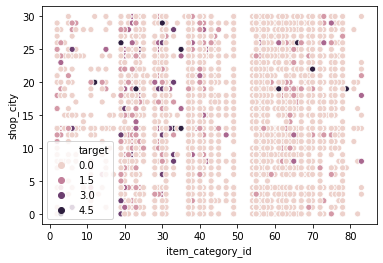

In [57]:
sns.scatterplot(x = 'item_category_id', y = 'shop_city', hue = 'target', data = df_for_plots.sample(frac = 0.001))

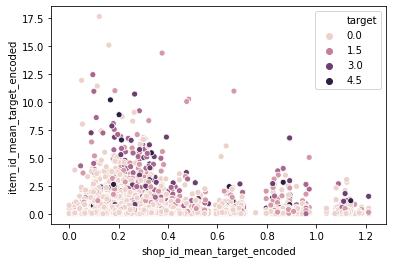

In [58]:
sns.scatterplot(x = 'shop_id_mean_target_encoded', y = 'item_id_mean_target_encoded', hue = 'target', data = df_for_plots.sample(frac = 0.001))

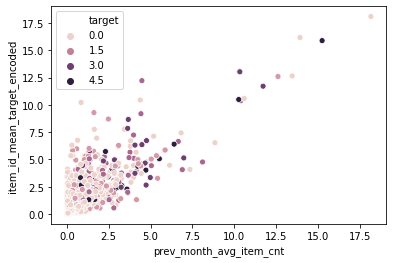

In [59]:
sns.scatterplot(x = 'prev_month_avg_item_cnt', y = 'item_id_mean_target_encoded', hue = 'target', data = df_for_plots.sample(frac = 0.001))

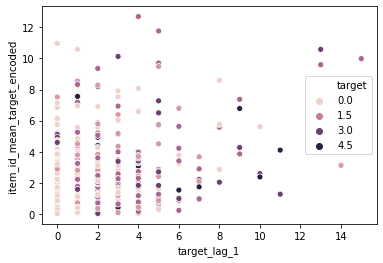

In [60]:
sns.scatterplot(x = 'target_lag_1', y = 'item_id_mean_target_encoded', hue = 'target', data = df_for_plots.sample(frac = 0.001))

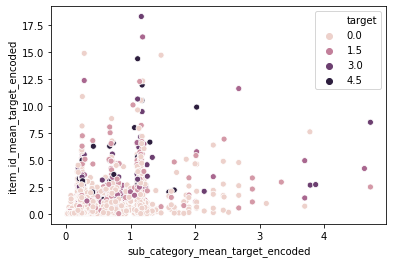

In [61]:
sns.scatterplot(x = 'sub_category_mean_target_encoded', y = 'item_id_mean_target_encoded', hue = 'target', data = df_for_plots.sample(frac = 0.001))

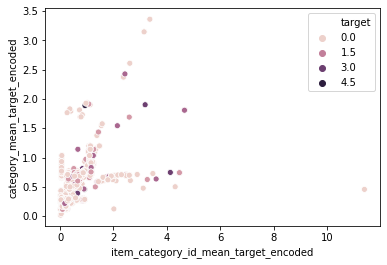

In [62]:
sns.scatterplot(x = 'item_category_id_mean_target_encoded', y = 'category_mean_target_encoded', hue = 'target', data = df_for_plots.sample(frac = 0.001))

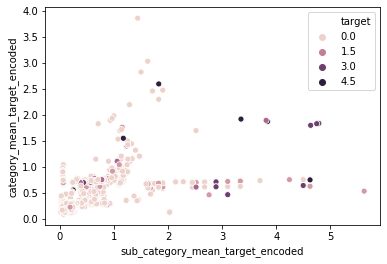

In [63]:
sns.scatterplot(x = 'sub_category_mean_target_encoded', y = 'category_mean_target_encoded', hue = 'target', data = df_for_plots.sample(frac = 0.001))

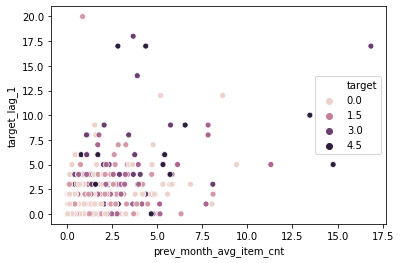

In [64]:
sns.scatterplot(x = 'prev_month_avg_item_cnt', y = 'target_lag_1', hue = 'target', data = df_for_plots.sample(frac = 0.001))

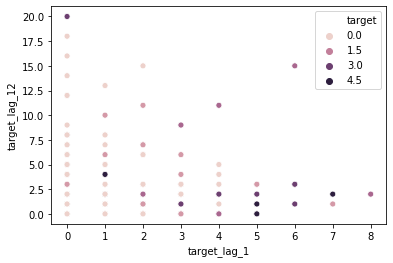

In [65]:
sns.scatterplot(x = 'target_lag_1', y = 'target_lag_12', hue = 'target', data = df_for_plots.sample(frac = 0.001))

### Train XGBoost

In [66]:
def run_xgboost(xgboost_params, xgboost_num_rounds, train_df, val_df):
    train_matrix = xgb.DMatrix(data=train_df.drop(columns = ['target']), label=train_df['target'].values)
    model = xgb.train(xgboost_params, train_matrix, xgboost_num_rounds)
    train_prediction = model.predict(train_matrix).clip(0,20)
    train_error = mean_squared_error(train_prediction, train_df['target'].values.clip(0,20))
    
    validation_matrix = xgb.DMatrix(data=val_df.drop(columns = ['target']))
    validation_predictions = model.predict(validation_matrix).clip(0,20)
    validation_error = mean_squared_error(validation_predictions, val_df['target'].clip(0,20))
    
    print('XGBoost training error: ', train_error)
    print('XGBoost validation error: ' + str(validation_error))
    print('XGBoost r2 score: ', r2_score(val_df['target'].values.clip(0,20), validation_predictions))
    return model, validation_error

In [67]:
train_df = features_df[features_df['date_block_num'] < 33]
val_df = features_df[features_df['date_block_num'] == 33]

In [68]:
xgboost_params = {'max_depth':12, 
         'subsample':0.25,
         'eta':0.2, 
         'gamma': 1000,
         'min_child_weight': 5,
         'eval_metric':'rmse'}
xgboost_num_rounds = 25

xgboost_model, xgboost_val_error = run_xgboost(xgboost_params, xgboost_num_rounds, train_df, val_df)

[14:21:31] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
XGBoost training error:  0.7989425940818542
XGBoost validation error: 0.8240809967598793
XGBoost r2 score:  0.3625599789518166


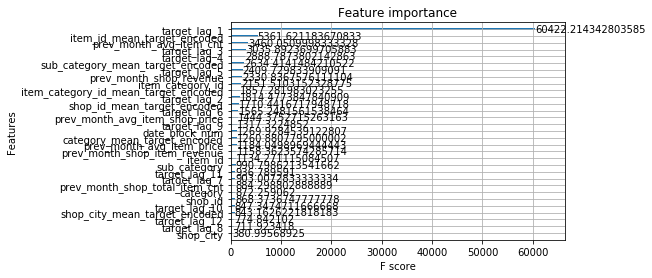

In [69]:
xgb.plot_importance(xgboost_model, importance_type = 'gain')

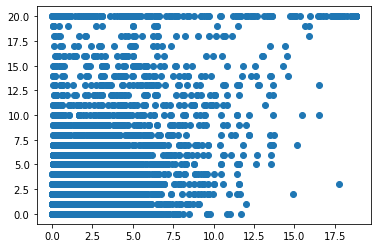

In [70]:
plt.scatter(xgboost_model.predict(xgb.DMatrix(data=val_df.drop(columns = ['target']))).clip(0,20), val_df['target'].clip(0,20))

### Prepare submission

In [79]:
submission_df = test.merge(features_df, on = ['item_id', 'shop_id', 'date_block_num'], how = 'left').drop(['ID'], axis = 'columns')
submission_df = submission_df[features_df.columns]
submission_df = submission_df.drop(['target'], axis = 'columns')

In [80]:
submission_matrix = xgb.DMatrix(data=submission_df)
submission_pred_xgboost = xgboost_model.predict(submission_matrix).clip(0,20)

In [81]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['item_cnt_month'] = pd.Series(submission_pred_xgboost)
submission.set_index('ID', inplace = True)
submission.to_csv('submission.csv')